# GWAS QC and Analysis
## Copyright Brian S. Cole, PhD 2017

A Jupyter Notebook for Reproducible Quality Control of Genotypes and Genotyped Samples Followed by Genotype-Phenotype Analysis using Cloud Computing and Open Source Tools.

This work presents an example GWAS workthrough.  Users are encouraged to use this example notebook to generate their own notebooks that document and visualize their GWAS analyses.  Commonly used tools are highlighted, including PLINK, R, Python, and Perl, however this notebook is flexible and users are encouraged to customize this workflow to fit the demands of their analysis.

This document can therefore serve as a template for customization, then the resulting analysis can be easily shared in notebook form.  Note that this does not hold if the user develops external scripts/programs that are called from this notebook.  Those must be included separately, for example in a hardware virtual machine image (e.g. AMI) or container service.

## Table of contents
1. Introduction
  1. Genotype-phenotype Association Studies (GWAS)
  2. GWAS QC Protects Against Spurious Results
  3. Individual-level QC Removes Samples
  4. Variant-level QC Removes Genetic Variants
  5. Harnessing the Cloud for Reproducible GWAS
2. Individual-level QC
  1. Gender Concordance
  2. Missing Genotypes
  3. Outlying Heterozygosity
  4. Identity-by-Descent Control (IBD)
  5. Removing Individuals that Failed QC
3. Variant-level QC
  1. Callrate Control (genotype missingness)
  2. Differential Callrate (for case/control studies)
  3. Hardy-Weinberg Equilibrium Control
  4. Minor Allele Frequency Control
  5. Removing Variants that Failed QC
4. (Optional) Population Structure
  1. Quantifying Population Structure
  2. Estimating Genetic Relationships
5. Case/control GWAS
  1. Logistic regression
  2. Covariate adjustment
  3. Interpreting Results
6. Quantitative Trait GWAS
  1. Linear Regression
  2. Covariate Adjustment
  3. Interpreting Results
7. Survival GWAS
  1. Cox Proportional Hazards Regression
  2. Covariate Adjustment
  3. Interpreting Results
8. Data Egress and Instance Termination
  1. Moving Data and Results Out
  2. Sharing Notebooks for Reproducible Analysis
  3. Cleanup and Termination

## Introduction
#### Genotype-Phenotype Association Studies (GWAS)
The advent of low-cost, high-throughput genotyping technologies has enabled scientific research into the association between variation in phenotypes within a set of unrelated individuals sampled from a population and the variation in genotypes within this set of samples.  This analysis, commonly referred to as Genome-Wide Association Study or GWAS, has the power to identify particular genotypes which are associated with quantitative traits, case/control status, survival outcomes, and other traits.  

Over the last decade, studies of thousands of traits have accumulated, ushering in a new era of knowledge integration. However, failure to replicate and reproduce GWAS results has led to a complicated situation in which the generalizability and utility of genotype-phenotype associations is not guaranteed by current analysis methodologies.  We propose that cloud computing and open source tools can provide enhanced reproducibility by coupling stateful, virtualized hardware with open-source software.  This document outlines a GWAS QC and analysis workflow which users can recreate using their own data, including modifications of the workflow to fit their needs.  The resulting notebook can be shared, version-controlled, and reproduced.

#### GWAS QC Protects Against Spurious Results
GWAS analyses typically require that several assumptions are met, otherwise the analysis is not valid.  The primary goal of GWAS Quality Control (QC) is to remove sources of false positive genotype-phenotype associations.  These sources of spurious results are the result of the statistical analysis, the technologies used to obtain genotypes, and the properties of genotypes within populations.

This notebook will use a QC approach tooled around the PLINK software (GPLv3) by Shaun Purcell and Christopher Chang, which is available at http://pngu.mgh.harvard.edu/purcell/plink/ and is described in the following work:

Purcell S, Neale B, Todd-Brown K, Thomas L, Ferreira MAR, Bender D, Maller J, Sklar P, de Bakker PIW, Daly MJ & Sham PC (2007) PLINK: a toolset for whole-genome association and population-based linkage analysis. American Journal of Human Genetics, 81.

The methodology behind the QC approach in this notebook is described in this work:

Anderson CA, Pettersson FH, Clarke GM, Cardon LR, Morris AP, Zondervan KT. Data quality control in genetic case-control association studies. Nature protocols. 2010;5(9):1564-1573. doi:10.1038/nprot.2010.116.


#### Individual-level QC Removes Samples
The goal of individual-level QC phase is to remove samples (sometimes called "subjects") which should not be included in the analysis.  These reasons include gender discordance between phenotype and genotype, relatedness to other samples which would violate the assumption of unrelated samples that underlies GWAS hypothesis testing, potential contamination of multiple samples which would yield unreliable genotyping, and low genotyping coverage which might indicate degraded DNA and/or technical failure of DNA preparation.  

#### Variant-level QC Removes Genetic Variants
The goal of the latter phase is to remove genotypes of poor quality.  Reasons for exclusion of individual genotypes include departure from Hardy Weinberg Equilibrium which might denote clustering failures during genotype calling (preventing one of two homozygous genotypes at a biallelic locus from being called, for example), absence of genotype calls from a subset of samples, significantly different genotyping rate between cases and controls, and (optionally) removal of rare variants which are unlikely to give rise to statistically significant association results for complex traits.

#### Harnessing the Cloud for Reproducible GWAS
Cloud computing provides abstractions for scalable, elastic, durable, safe, affordable, on-demand, reproducible computation.  Importantly, this notebook can be run on an Amazon Web Services (AWS) Elastic Compute Cloud (EC2) instance coupled with encrypted Elastic Block Storage (EBS) volume to hold the user's data during analyiss.  The resulting notebook can be used to create a git repository for version control, cloning off the cloud, and sharing with others.  Importantly, the notebook can be customized and shared, documenting a user's analysis in a reproducible way.
The goal is to utilize notebooks as a framework for analysis in the cloud, decoupling the analyst from the computational infrastructure as entirely as is possible.  The cloud then provides mechanisms for snapshotting data (EBS snapshots), storing notebooks for distribution and reuse (S3), containerizing workflows (ECS), collaboration and resource management, and much more.
Users may also connect to their EC2 instances and run all commands documented here individually.  This is recommended for users who wish to develop customized tools (for example, scripts) to supplement this notebook.  It is important to note that any external tools that this notebook uses will then become reproducibility dependencies.  Users are therefore encouraged to use open source licenses and create their own virtual appliances which include their external tools (e.g. custom scripts) by using Amazon Machine Images or other technology.

    

In [13]:
'''Prepare the notebook. Run this cell first.'''
import os, re, sys
import pandas as pd
import numpy as np
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [14]:
'''Make analysis directory and upload your data'''

import os
study_dir = '/home/brian/clink/NEIGHBOR/' #Can change this variable to suit your study.
if not os.path.isdir(study_dir): os.mkdir(study_dir)
%cd {study_dir}

#You can either upload data to the EC2 instance using the key pair you specified at instance launch,
#  for instance using scp from a system that has your data,
#  or you can fetch the data from this instance using SFTP/rsync/curl/wget/s3

#Remember that if you want to pull data from a private S3 bucket, the EC2 instance needs to assume an IAM role,
#  and that bucket must be configured for the EC2 instance's IAM role.

#In this example, I used scp from a firewalled and secured workstation to securely upload a Plink study to the EC2 instance.
#I used a command like this from my workstation:
#scp -i my_key_pair.pem my_study.* ec2-user@<IPv4_public_IP>:/gwas/my_study/
#  ..where <IPv4_public_IP> is the public IPv4 address of the EC2 instance running this notebook.

input_filestem  = 'merged_neighbor' #Set this variable to the Plink filestem of your study.
output_filestem = 'clean-' + input_filestem #Generate a new filestem for post-QC data.

/clink/NEIGHBOR


## 2: Individual-level QC
Our strategy here will be to identify individuals with discordant genders, too many missing genotypes, and outlying heterozygosity.  We'll save the IDs of these individuals to text files, then at the end we'll combine these files and remove the individuals who failed individual-level QC.  We'll generate a new file with clean individuals, and this file will be used in variant-level QC.

### 2A: Gender Concordance
Gender concordance serves as a check of your phenotype and genotype data.  You should see very few, if any, instances in which the phenotypic gender, which is provided in the Plink \*.fam file, does not match Plink's guess from looking at the genotypes.  All individuals who fail this step will be excluded from further analysis.

In [21]:
'''Run sex check using plink.'''

#This should generate a *.sexcheck file for our study
!plink --bfile $input_filestem --check-sex --out $input_filestem

PLINK v1.90b4.1 64-bit (30 Mar 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --check-sex
  --out merged_neighbor

64329 MB RAM detected; reserving 32164 MB for main workspace.
655216 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53

In [23]:
sexcheck_file = input_filestem + '.sexcheck'
sexprobs_file = input_filestem + '.sexprobs'

!fgrep PROBLEM $sexcheck_file > $sexprobs_file
sexproblems = !cat $sexprobs_file | wc -l
print("Number of gender discordances detected: " + str(sexproblems))

#Save the FID and IID of the individuals that failed qc, if any.
#It's okay to generate an empty file here - we'll count the lines of each fail-* file later for a sumamry.
!perl -lne 's/^\s+//; @f = split; print join "\t", (@f[0..1])' $sexprobs_file >fail-sexcheck-qc.txt

#At this point, inspect the reasons for any gender discordances.  In this case, some genders are missing in the ped file:
!head -1 $sexcheck_file #For the header.
!head -5 $sexprobs_file #Check out the first 5 discordances.

Number of gender discordances detected: ['151']
         FID          IID       PEDSEX       SNPSEX       STATUS            F
      ME8001       ME8001            0            2      PROBLEM     -0.03585
      ME8002       ME8002            0            1      PROBLEM            1
      ME8003       ME8003            0            1      PROBLEM            1
      ME8004       ME8004            0            2      PROBLEM    -0.004742
      ME8005       ME8005            0            2      PROBLEM     -0.04665


In [24]:
'''Remove SNPs that are missing in too many samples.'''
!plink --bfile $input_filestem --geno 0.01 --make-bed --out $output_filestem

PLINK v1.90b4.1 64-bit (30 Mar 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean-merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --geno 0.01
  --make-bed
  --out clean-merged_neighbor

64329 MB RAM detected; reserving 32164 MB for main workspace.
655216 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to clean-merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%4

In [25]:
'''Remove samples that have too many missing SNPs.
Generate missingness and heterozygosity reports using Plink.'''
!plink --bfile $input_filestem --missing --out $input_filestem
!plink --bfile $input_filestem --het     --out $input_filestem

PLINK v1.90b4.1 64-bit (30 Mar 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --missing
  --out merged_neighbor

64329 MB RAM detected; reserving 32164 MB for main workspace.
655216 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%

In [26]:
'''Visualize missingness and heterozygosity from reports.'''

imiss_file = input_filestem + '.imiss'
het_file   = input_filestem + '.het'


#!head {imiss_file} #See how Plink generates some extra whitespace...
!perl -i.bak -lpe 's/^\s+//; s/\s+/\t/g;' {imiss_file} {het_file} 
#!head {imiss_file} #Uncomment to see how this Perl one-liner cleaned up these two files for easy reading.
#Now the whitespace is cleaned up, and the original het and imiss files are backed up as *.het.bak and *.imiss.bak

imiss = pd.read_table(imiss_file, sep="\t")
het   = pd.read_table(het_file,   sep="\t")

het['meanHet'] = (het['N(NM)'] - het['O(HOM)']) / het['N(NM)'] #Compute mean heterozygosity.
imiss['logF_MISS'] = np.log10(imiss['F_MISS']) #This might generate a RuntimeWarning: "divide by zero encountered in log10" for genotypes that weren't missing in anybody.

#imiss.head()

imiss.describe()


,N_MISS,N_GENO,F_MISS,logF_MISS
count,5183.000000,5183.000000,5183.000000,5183.000000
mean,98672.371214,655193.186186,0.150601,-0.822191
std,894.183136,20.370968,0.001365,0.003837
min,98194.000000,655175.000000,0.149900,-0.824198
25%,98287.000000,655175.000000,0.150000,-0.823909
50%,98387.000000,655175.000000,0.150200,-0.823330
75%,98652.000000,655216.000000,0.150600,-0.822175
max,115081.000000,655216.000000,0.175600,-0.755475


Summary of log10(missingness): [-0.8242 -0.8239 -0.8233 -0.8222 -0.8222 -0.7555]
Summary of mean heterozygosity: [ 0.2349  0.3192  0.3207  0.3207  0.3222  0.3608]


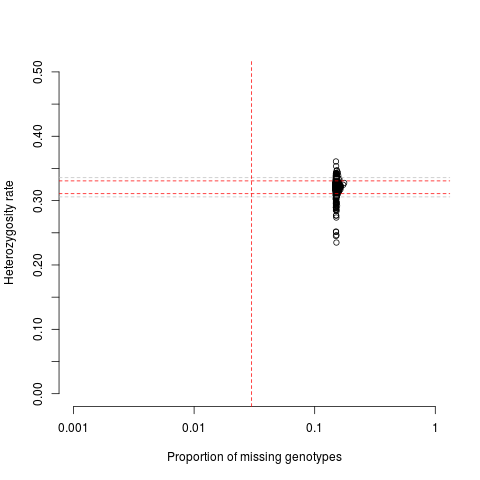

In [28]:
'''Plot missingness versus heterozygosity. Use Rmagic.'''

%Rpush imiss_file het_file
%R imiss <- read.table(imiss_file, header=T)
%R het   <- read.table(het_file,   header=T)

#Calculate the log10 of the F_MISS and the mean heterozygosity (among non-missing genotypes).
%R imiss$logF_MISS <- log10(imiss$F_MISS)
%R het$meanHet     <-  (het$N.NM. - het$O.HOM.)/het$N.NM.

%R -o summary_logF_MISS summary_logF_MISS <- summary(imiss$logF_MISS)
print("Summary of log10(missingness): " + str(summary_logF_MISS))

%R -o summary_meanHet summary_meanHet <- summary(het$meanHet)
print("Summary of mean heterozygosity: " + str(summary_meanHet))

#Plot the logF_MISS against the mean heterozygosity.
#You can modify this plotting command to focus on your range of interest.
%R plot(imiss$logF_MISS, het$meanHet, xlim=c(-3,0), ylim=c(0,0.5), pch=1, xlab="Proportion of missing genotypes", ylab="Heterozygosity rate",axes=F); axis(2,at=c(0,0.05,0.10,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5),tick=T); axis(1,at=c(-3,-2,-1,0),labels=c(0.001,0.01,0.1,1)); abline(h=mean(het$meanHet) - (2 * sd(het$meanHet)), col="RED",  lty=2); abline(h=mean(het$meanHet) - (3 * sd(het$meanHet)), col="gray", lty=2); abline(h=mean(het$meanHet) + (2 * sd(het$meanHet)), col="red",  lty=2); abline(h=mean(het$meanHet) + (3 * sd(het$meanHet)), col="gray",  lty=2); abline(v=-1.522879, col="red", lty=2)


In [29]:
'''Write file containing FID:IID pairs for individuals with outlying heterozygosity'''
%R het.filt <- het[which( het$meanHet > (mean(het$meanHet) + 3 * sd(het$meanHet)) | het$meanHet < (mean(het$meanHet) - 3 * sd(het$meanHet)) ),]
%R write.table(het.filt[,c(0,1)], file="fail-het-qc.txt", sep="\t", row.names=F, quote=F)

In [31]:
fail_het_qc_count = !cat fail-het-qc.txt | wc -l

print("Number of individuals who failed heterozygosity QC:" + str(fail_het_qc_count))

Number of individuals who failed heterozygosity QC:['103']


In [ ]:
'''Exclude genetic variants that are not present in at least 99% of samples.'''
!plink --bfile $input_filestem --geno 0.01 --make-bed --out $output_filestem

### 2B: Missing Genotypes
The purpose of this step is to identify samples that have too many missing genotypes.  This may indicate a technical failure for the sample because near-complete genotyping is expected.  If this is true, then few or no samples should fail this step.  Any samples that do are excluded from further analysis.
Critical note: if a subset of genotypes are missing in all or nearly all samples, this step, which excludes samples that have too many missing genotypes, could exclude all or nearly all samples.  In this case, the variants in the study can be pruned first (see 3A: Callrate Control) to remove variants that are not present in at least 97% of samples, say.

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --missing
  --out merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
655216 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%

,N_MISS,N_GENO,F_MISS,logF_MISS
count,5183.000000,5183.000000,5183.000000,5183.000000
mean,98672.371214,655193.186186,0.150601,-0.822191
std,894.183136,20.370968,0.001365,0.003837
min,98194.000000,655175.000000,0.149900,-0.824198
25%,98287.000000,655175.000000,0.150000,-0.823909
50%,98387.000000,655175.000000,0.150200,-0.823330
75%,98652.000000,655216.000000,0.150600,-0.822175
max,115081.000000,655216.000000,0.175600,-0.755475


Summary of log10(missingness): [-0.8242 -0.8239 -0.8233 -0.8222 -0.8222 -0.7555]
Summary of mean heterozygosity: [ 0.2349  0.3192  0.3207  0.3207  0.3222  0.3608]


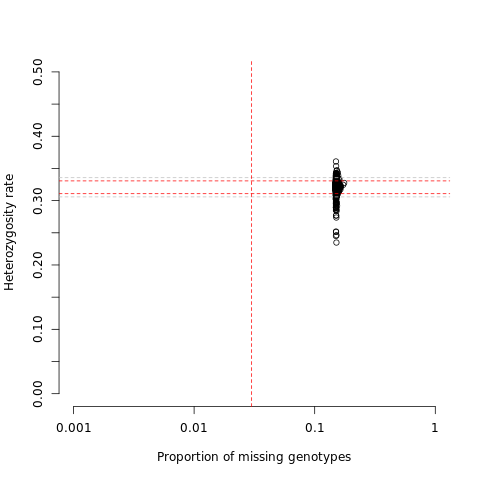

In [32]:
'''Exclude individuals with less than 99% callrate (1% or more of genetic variants are missing in that sample).'''
#First, generate missingness reports:
!plink --bfile $output_filestem --missing --out $output_filestem
imiss_file = output_filestem + '.imiss'
#Clean up the whitespace:
!perl -i.bak -lpe 's/^\s+//; s/\s+/\t/g;' $imiss_file

PLINK v1.90b4.1 64-bit (30 Mar 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean-merged_neighbor.log.
Options in effect:
  --bfile clean-merged_neighbor
  --missing
  --out clean-merged_neighbor

64329 MB RAM detected; reserving 32164 MB for main workspace.
547812 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to clean-merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%

Number of individuals who failed heterozygosity QC:['103']


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean-merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --geno 0.01
  --make-bed
  --out clean-merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
655216 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to clean-merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean-merged_neighbor.log.
Options in effect:
  --bfile clean-merged_neighbor
  --missing
  --out clean-merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
547812 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to clean-merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%

In [23]:
'''Isolate the FID:IID pairs for individuals that failed callrate QC.'''
%Rpush imiss_file
%R imiss <- read.table(imiss_file, header=T)
%R str(imiss)
%R write.table(imiss[which(imiss$F_MISS >= 0.01),c(1,2)], file='fail-imiss-qc.txt', quote=F, row.names=F, sep="\t")
imiss_fail_count = !cat fail-imiss-qc.txt | wc -l
print "Number of samples that failed callrate QC: " + str(imiss_fail_count)

'data.frame':	5183 obs. of  6 variables:
 $ FID       : Factor w/ 5073 levels "ME8001","ME8002",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ IID       : Factor w/ 5183 levels "DU9001","DU9002",..: 51 52 53 54 55 56 57 58 59 60 ...
 $ MISS_PHENO: Factor w/ 2 levels "N","Y": 2 2 2 2 2 2 2 2 2 2 ...
 $ N_MISS    : int  46 37 34 27 27 77 634 32 27 27 ...
 $ N_GENO    : int  547804 547804 547804 547804 547804 547804 547804 547804 547804 547804 ...
 $ F_MISS    : num  8.40e-05 6.75e-05 6.21e-05 4.93e-05 4.93e-05 ...


Number of samples that failed callrate QC: ['20']


In [24]:
'''Use plink to exclude those samples that failed callrate QC.'''
!plink --bfile $output_filestem --remove fail-imiss-qc.txt --make-bed --out $output_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean-merged_neighbor.log.
Options in effect:
  --bfile clean-merged_neighbor
  --make-bed
  --out clean-merged_neighbor
  --remove fail-imiss-qc.txt

995 MB RAM detected; reserving 497 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
547812 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to clean-merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
--remove: 5164 people remaining.
Using 1 thread.
Before main variant filters, 5164 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%3

In [25]:
'''Exclude rare variants: genetic markers with less than 1% minor allele frequency.'''
!plink --bfile $output_filestem --maf 0.01 --make-bed --out $output_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean-merged_neighbor.log.
Options in effect:
  --bfile clean-merged_neighbor
  --maf 0.01
  --make-bed
  --out clean-merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
547812 variants loaded from .bim file.
5164 people (2291 males, 2742 females, 131 ambiguous) loaded from .fam.
Ambiguous sex IDs written to clean-merged_neighbor.nosex .
5033 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 5164 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40

In [26]:
'''Exclude related samples.'''
'''Generate LD-pruned variants first.'''
!plink --bfile $output_filestem --indep-pairwise 50 5 0.2 --out $output_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean-merged_neighbor.log.
Options in effect:
  --bfile clean-merged_neighbor
  --indep-pairwise 50 5 0.2
  --out clean-merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
528467 variants loaded from .bim file.
5164 people (2291 males, 2742 females, 131 ambiguous) loaded from .fam.
Ambiguous sex IDs written to clean-merged_neighbor.nosex .
5033 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 5164 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54

In [27]:
'''If the above output pruned too few or too many SNPs, adjust the linkage R^2 value 
Increase R^2 to retain more SNPs, decrease to prune more.
The goal is to end up with about 100k SNPs for a GWAS study (>= 500k SNPs genome-wide).
Then proceed with identification of related samples.'''
prune_in_file = output_filestem + '.prune.in'
unlinked_variant_count = !cat $prune_in_file | wc -l
print "Unlinked (LD-pruned) genetic variant count: " + str(unlinked_variant_count)
!plink --bfile $output_filestem --extract $prune_in_file --genome --out $output_filestem
#That command should generate a *.genome file.

Unlinked (LD-pruned) genetic variant count: ['112744']
PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean-merged_neighbor.log.
Options in effect:
  --bfile clean-merged_neighbor
  --extract clean-merged_neighbor.prune.in
  --genome
  --out clean-merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
528467 variants loaded from .bim file.
5164 people (2291 males, 2742 females, 131 ambiguous) loaded from .fam.
Ambiguous sex IDs written to clean-merged_neighbor.nosex .
5033 phenotype values loaded from .fam.
--extract: 112744 variants remaining.
Using 1 thread.
Before main variant filters, 5164 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%

In [28]:
genome_file = output_filestem + '.genome'
#Clean up the whitespace:
!perl -i.bak -lpe 's/^\s+//; s/\s+/\t/g;' $genome_file
genome_file_line_count = !wc -l $genome_file
print "Line count in genome file (used for relationship estimation): " + str(genome_file_line_count)
!head $genome_file

Line count in genome file (used for relationship estimation): ['13330867 clean-merged_neighbor.genome']
FID1	IID1	FID2	IID2	RT	EZ	Z0	Z1	Z2	PI_HAT	PHE	DST	PPC	RATIO
ME8001	ME8001	ME8002	ME8002	UN	NA	1.0000	0.0000	0.0000	0.0000	NA	0.745242	0.0535	1.8941
ME8001	ME8001	ME8003	ME8003	UN	NA	1.0000	0.0000	0.0000	0.0000	NA	0.744817	0.0055	1.8363
ME8001	ME8001	ME8004	ME8004	UN	NA	1.0000	0.0000	0.0000	0.0000	NA	0.746071	0.5046	2.0008
ME8001	ME8001	ME8005	ME8005	UN	NA	1.0000	0.0000	0.0000	0.0000	NA	0.747932	0.0500	1.8920
ME8001	ME8001	ME8006	ME8006	UN	NA	1.0000	0.0000	0.0000	0.0000	NA	0.746616	0.2204	1.9484
ME8001	ME8001	ME8007	ME8007	UN	NA	1.0000	0.0000	0.0000	0.0000	NA	0.747042	0.2199	1.9482
ME8001	ME8001	ME8008	ME8008	UN	NA	1.0000	0.0000	0.0000	0.0000	NA	0.745406	0.0870	1.9104
ME8001	ME8001	ME8009	ME8009	UN	NA	1.0000	0.0000	0.0000	0.0000	NA	0.744062	0.0177	1.8630
ME8001	ME8001	ME8010	ME8010	UN	NA	1.0000	0.0000	0.0000	0.0000	NA	0.745033	0.0328	1.8795


In [29]:
'''Generate a file containing FID:IID pairs of individuals to be excluded on the basis of relatedness.
Exclude the individual with greater missingness from any pair of individuals that are related more than first cousins.'''
imiss, removed = dict(), set()

with open(imiss_file) as imiss_in, open(genome_file) as genome_in, open('fail-IBD-QC.txt', 'w') as fail_IBD_out:
    #Read the missingness into a dictionary.
    header = imiss_in.readline()
    for line in imiss_in:
        fid, iid, miss_pheno, n_miss, n_geno, f_miss = line.rstrip().split("\t") #File was already whitespace-cleaned.
        imiss[(fid, iid)] = float(f_miss) #Key by FID:IID tuple, value by F_MISS (missing frequency).
        
    #Now exclude related samples. Drop whichever one has higher missingness.
    header = genome_in.readline()
    for line in genome_in:
        fid1, iid1, fid2, iid2, rt, ez, z0, z1, z2, pi_hat, phe, dst, ppc, ratio = line.rstrip().split("\t")
        if float(pi_hat) > 0.185:
            if imiss[(fid1, iid1)] >= imiss[(fid2, iid2)]: #The first sample has higher missingness.
                if (fid1, iid1) not in removed:
                    fail_IBD_out.write("\t".join([fid1, iid1]) + "\n")
                    removed.add((fid1, iid1)) #Remember that we already excluded this FID:IID pair.
            else: #The second sample has higher missingness.
                if (fid2, iid2) not in removed:
                    fail_IBD_out.write("\t".join([fid2, iid2]) + "\n")
                    removed.add((fid2, iid2))

fail_IBD_count = !cat fail-IBD-QC.txt | wc -l
print "Number of samples that failed IBD QC: " + str(fail_IBD_count)

Number of samples that failed IBD QC: ['193']


In [30]:
'''Now exclude the related samples from the study.'''
!plink --bfile $output_filestem --remove fail-IBD-QC.txt --make-bed --out $output_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean-merged_neighbor.log.
Options in effect:
  --bfile clean-merged_neighbor
  --make-bed
  --out clean-merged_neighbor
  --remove fail-IBD-QC.txt

995 MB RAM detected; reserving 497 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
528467 variants loaded from .bim file.
5164 people (2291 males, 2742 females, 131 ambiguous) loaded from .fam.
Ambiguous sex IDs written to clean-merged_neighbor.nosex .
5033 phenotype values loaded from .fam.
--remove: 4971 people remaining.
Using 1 thread.
Before main variant filters, 4971 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%

In [31]:
'''Now that related samples have been excluded, repeat the marker callrate, sample callrate, and MAF filtering.'''

'''Exclude genetic variants that are not present in at least 99% of samples.'''
!plink --bfile $output_filestem --geno 0.01 --make-bed --out $output_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean-merged_neighbor.log.
Options in effect:
  --bfile clean-merged_neighbor
  --geno 0.01
  --make-bed
  --out clean-merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
528467 variants loaded from .bim file.
4971 people (2245 males, 2655 females, 71 ambiguous) loaded from .fam.
Ambiguous sex IDs written to clean-merged_neighbor.nosex .
4900 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 4971 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40

In [32]:
'''Exclude individuals with less than 99% callrate (1% or more of genetic variants are missing in that sample).'''
#First, generate missingness reports:
!plink --bfile $output_filestem --missing --out $output_filestem
imiss_file = output_filestem + '.imiss'
#Clean up the whitespace:
!perl -i.bak -lpe 's/^\s+//; s/\s+/\t/g;' $imiss_file

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to clean-merged_neighbor.log.
Options in effect:
  --bfile clean-merged_neighbor
  --missing
  --out clean-merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
528442 variants loaded from .bim file.
4971 people (2245 males, 2655 females, 71 ambiguous) loaded from .fam.
Ambiguous sex IDs written to clean-merged_neighbor.nosex .
4900 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 4971 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%5